# A Quick Guide to Currency Conversion  

In an ever increasingly globalized world, businesses are more likely to record transactions in multiple currencies: a freelancer may charge according to the local currency of their latest project; a sales firm might send a team to potential clients in another country, and have to reimburse charges accrued in another currency. 

Having a multi currency business adds a complication to fact finding and analysis. Even ignoring changing exchange rates based on transaction date, knowing the income or outflow of money is no longer as simple as adding up the charges. An amount column may not necessarily be enough information to know how much was spent--the currency column becomes an important input as well.

So, what do we do if we want to run analytics on our transactions? How do we keep the subtotals and totals accurate/true in our cube? Consider the following simple example, where charges were incurred across multiple locations, in multiple currencies.

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=currency-conversion" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Discover-Atoti-now.png" alt="Try Atoti"></a></div>

In [1]:
import atoti as tt
import pandas as pd

session = tt.Session.start()
transactions = session.read_pandas(
    pd.DataFrame(
        columns=["Xid", "Ccy", "Cat", "Itm", "Amt"],
        data=[
            (1, "USD", "Food", "Lunch", 10),
            (2, "USD", "Transport", "Train Ticket", 50),
            (3, "USD", "Equipment", "Paint", 20),
            (4, "GBP", "Transport", "Rental", 40),
            (5, "GBP", "Transport", "Gas", 30),
            (6, "EUR", "Equipment", "Paint", 10),
            (7, "EUR", "Food", "Breakfast", 5),
            (8, "CAD", "Transport", "Rental", 90),
            (9, "CAD", "Food", "Lunch", 12),
            (10, "USD", "Food", "Dinner", 35),
            (11, "GBP", "Transport", "Bus", 3),
            (12, "GBP", "Food", "Breakfast", 4),
            (13, "EUR", "Food", "Lunch", 12),
            (14, "EUR", "Transport", "Train Ticket", 6),
            (15, "CAD", "Food", "Dinner", 41),
        ],
    ),
    table_name="EmpTransactions",
    keys=["Xid"],
)

transactions.head()

/Users/aya/Desktop/atoti/.venv/lib/python3.11/site-packages/atoti/session.py:468: RuntimeWarning: The license key is about to expire, contact ActiveViam to get a new license key in the coming 5 days.
  session._warn_if_license_about_to_expire()


,Ccy,Cat,Itm,Amt
Xid,,,,
13,EUR,Food,Lunch,12
14,EUR,Transport,Train Ticket,6
1,USD,Food,Lunch,10
15,CAD,Food,Dinner,41
2,USD,Transport,Train Ticket,50


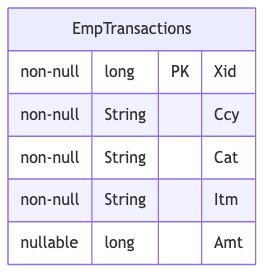

In [2]:
cube = session.create_cube(transactions, mode="auto")
h, l, m = cube.hierarchies, cube.levels, cube.measures

session.tables.schema

In the two cells above, we created a cube using Atoti, in something called auto mode.  This means Atoti will create hierarchies and measures based off the underlying datatypes.  Let's see what we have via a simple pivot table visualization.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
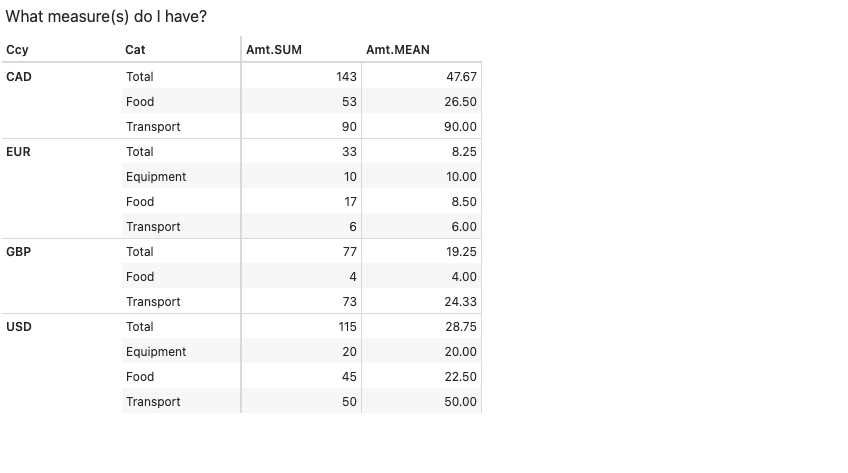

In [3]:
session.widget

As this pivot table is laid out, with currency as the left most bucketing, the subtotals for the mean and sum amounts make sense--but the grand total does not.  After all, what would 143 (CAD) + 33 (EUR) + 77 (GBP) + 115 (USD) = 368 even mean?  These are not currencies with exchange rates of one.

One way to handle this is to hide the grand total row in our table. But what if we wanted to compute these measures in a specific currency? How do we combine the information from our currency table with the transaction table? Let's assume the base opperation for our business is in the United States, hence conducts its business in USD.

For this exploration, we'll use a simple conversion dataframe.

In [4]:
usd_conv = session.read_pandas(
    pd.DataFrame(
        columns=["From", "To", "Rate"],
        data=[
            ("USD", "USD", 1.0000),
            ("CAD", "USD", 0.7768),
            ("EUR", "USD", 1.1282),
            ("GBP", "USD", 1.3319),
        ],
    ),
    table_name="ccy_conv",
    keys=["From"],
)

We'll use the *From* column of our conversion table to map to our transaction table's *Ccy* column.

In [5]:
transactions.join(usd_conv, transactions["Ccy"] == usd_conv["From"])

Let's freshly create a measure for the *Amt* column.

We'll use **tt.single_value()** here.  Using the *levels* parameter, we can set up which level(s) we want to require for the measure to express a value. Since this amount only makes sense with its currency, I'll set the currency level here.

In [6]:
m["Amt"] = tt.where(~l["Ccy"].isnull(), tt.agg.single_value(transactions["Amt"]))

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
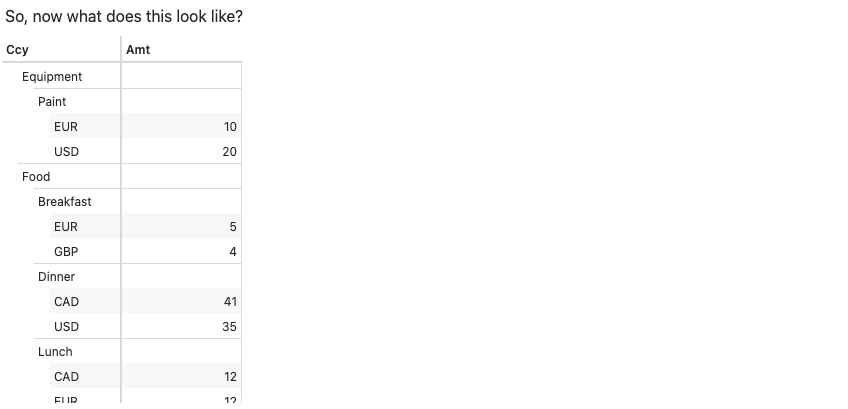

In [7]:
session.widget

What about if we wanted to create a new measure which gives us the total USD cost of each of these transactions?  For this, we would need to apply the currency conversion rate.  Let's first create a measure reading in the *Rate* data.

In [8]:
m["Rate"] = tt.agg.single_value(usd_conv["Rate"])

Since our two tables are joined via their "Ccy" and "From" columns, respectively, we can simply multiply the two measures and aggregate.  In fact, since all of this is in USD, having the totals also make sense, so we can aggregate them.

In [9]:
m["Amt USD"] = tt.agg.sum(
    m["Amt"] * m["Rate"], scope=tt.OriginScope(levels={l["Cat"], l["Ccy"]})
)

Now, if we check to see the amount vs their value in USD, we see we have the rate applied.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
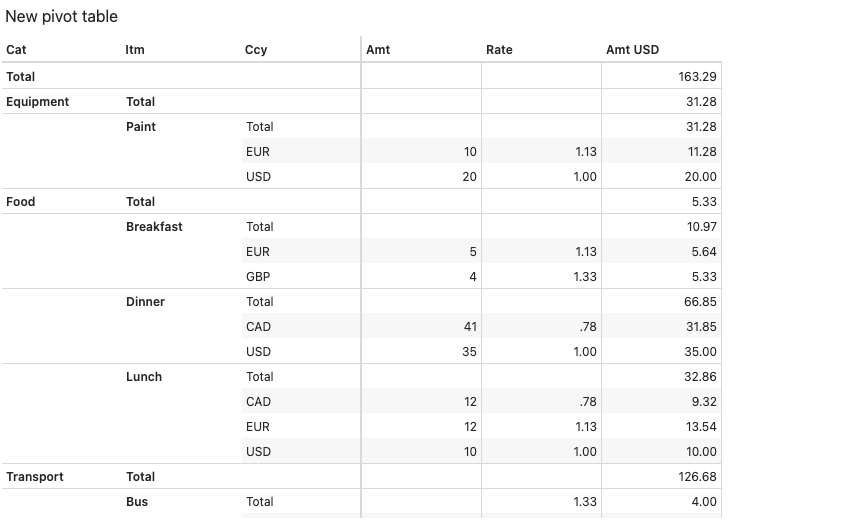

In [10]:
session.widget

So, how do we clean up the measures with which we began?  Afterall, we still see then in the widget editor.  We can either hide or delete measures, as appropriate.  Hiding measures make sense when the measure is used in a computation elsewhere.  Since we created our measures from scratch, we can safely delete **m\["Amt.SUM"\]** and **m\["Amt.MEAN"\]**.

Verifying the measures in our cube, as well as in the content editor, we see we're safe to pass this analysis along--no one will get confused by the facts we have.

<img src="https://data.atoti.io/notebooks/currency-conversion/img/deleting-measures.gif" width="750" align="left" />

A note about the newly creating Amt USD measure:  it is still accurate regardless of the order of our hierarchies, allowing us to view the transaction costs from multiple perspectives.

Open the notebook in JupyterLab with the Atoti JupyterLab extension enabled to build this widget.
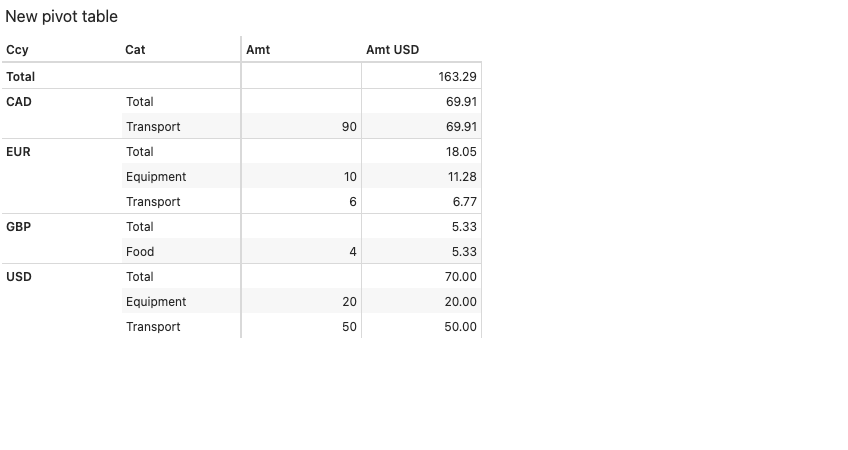

In [11]:
session.widget

<div style="text-align: center;" ><a href="https://www.atoti.io/?utm_source=gallery&utm_content=currency-conversion" target="_blank" rel="noopener noreferrer"><img src="https://data.atoti.io/notebooks/banners/Your-turn-to-try-Atoti.jpg" alt="Try Atoti"></a></div>